## Build vocab

In [73]:
SEQUENCE_LENGTH = 8

In [74]:
import pandas as pd
df = pd.read_csv("data/songdata.zip")
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [75]:
from pathlib import Path
import util

path = Path("chars.pkl")
chars = list()
if path.is_file():
    chars = util.load_vocab(path)
    print("Loaded from file")
else:
    vocab = set()
    for song in df["text"]:
        chars = set(song)
        vocab = vocab.union(chars)
    chars = list(vocab)
    util.write_vocab(path, chars)
    print("Generated from source")
    
vocab_size = len(chars)
print("Vocab size:", vocab_size)

Loaded from file
Vocab size: 76


In [76]:
char2idx = { char:i for i,char in enumerate(chars) }
idx2char = { i:char for i,char in enumerate(chars) }

In [77]:
song_count = len(df['text'])
train_size = int(song_count * 0.7)
test_dev_size = int((song_count - train_size) * 0.5)
print("Total number of songs:", song_count)
print("Number of songs for training:", train_size)
print("Number of songs for dev/test:", test_dev_size)

Total number of songs: 57650
Number of songs for training: 40355
Number of songs for dev/test: 8647


In [78]:
df = df.sample(frac=1).reset_index(drop=True)
songs_train = df['text'][:train_size].reset_index(drop=True)
songs_dev = df['text'][train_size:train_size+test_dev_size].reset_index(drop=True)
songs_test = df['text'][train_size+test_dev_size:].reset_index(drop=True)
print("Train:", len(songs_train))
print("Dev:", len(songs_dev))
print("Test:", len(songs_test))

Train: 40355
Dev: 8647
Test: 8648


## Build model

In [91]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, GRU, Bidirectional
from keras.layers import LeakyReLU
from pathlib import Path
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop

checkpoint = ModelCheckpoint("weights_char_{epoch:01d}.h5",
    monitor='loss',
    verbose=1,
    mode='auto',
    period=1,
    save_weights_only=True)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

def build_model(vocab_size):
    model = Sequential()
    model.add(LSTM(512, input_shape=(SEQUENCE_LENGTH, vocab_size)))
    model.add(Dropout(0.4))
    #model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer="rmsprop", metrics = ['accuracy'])
    return model

model = build_model(vocab_size)
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 512)               1206272   
_________________________________________________________________
dropout_27 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 76)                38988     
Total params: 1,245,260
Trainable params: 1,245,260
Non-trainable params: 0
_________________________________________________________________


## Generate samples and fit

In [92]:
def build_samples(song, buffer_length):
    tokens = song

    x_train = []
    y_train = []
    for i in range(0, len(song)):
        if i+buffer_length+1 >= len(tokens):
            continue
            
        x_train.append(tokens[i:i+buffer_length])
        y_train.append(tokens[i+buffer_length])

    return x_train,y_train

In [93]:
import math
from random import shuffle
import numpy as np

batch_size = 256
history = LossHistory()

def generate_batches(songs, batch_size):
    x_train, y_train = [], []
    for song in songs:
        xs, ys = build_samples(song, SEQUENCE_LENGTH)
        x_train.extend(xs)
        y_train.extend(ys)
        if len(x_train) >= batch_size:
            yield x_train[0:batch_size], y_train[0:batch_size]
            x_train = x_train[batch_size:]
            y_train = y_train[batch_size:]
    if len(x_train) > 0:
        yield x_train, y_train

def generate_samples(songs, batch_size):
    while True:
        batches = generate_batches(songs, batch_size)
        for xs_batch, ys_batch in batches:
            c = list(zip(xs_batch, ys_batch))
            shuffle(c)
            xs_batch, ys_batch = zip(*c)

            batch_size = len(xs_batch)
            x_train = np.zeros((batch_size, SEQUENCE_LENGTH, vocab_size))
            y_train = np.zeros((batch_size, vocab_size))

            for i in range(batch_size):
                x_train[i] = util.one_hot_encode_sequence(xs_batch[i], char2idx)
                y_train[i] = util.one_hot_encode(ys_batch[i], char2idx)

            yield x_train, y_train

model.fit_generator(generate_samples(songs_train, batch_size), samples_per_epoch=300, epochs=10, callbacks=[history, checkpoint])

/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=10, callbacks=[<__main__..., steps_per_epoch=300)`


Epoch 1/10
300/300 [==============================] - 20s 66ms/step - loss: 2.8362 - accuracy: 0.2635

Epoch 00001: saving model to weights_char_1.h5
Epoch 2/10
300/300 [==============================] - 20s 68ms/step - loss: 2.3146 - accuracy: 0.3685

Epoch 00002: saving model to weights_char_2.h5
Epoch 3/10
300/300 [==============================] - 21s 70ms/step - loss: 2.1057 - accuracy: 0.4160

Epoch 00003: saving model to weights_char_3.h5
Epoch 4/10
300/300 [==============================] - 23s 77ms/step - loss: 2.0272 - accuracy: 0.4406

Epoch 00004: saving model to weights_char_4.h5
Epoch 5/10
300/300 [==============================] - 24s 80ms/step - loss: 1.9037 - accuracy: 0.4652

Epoch 00005: saving model to weights_char_5.h5
Epoch 6/10
300/300 [==============================] - 25s 84ms/step - loss: 1.8155 - accuracy: 0.4893

Epoch 00006: saving model to weights_char_6.h5
Epoch 7/10
300/300 [==============================] - 26s 87ms/step - loss: 1.8328 - accuracy: 0.486

## Model evaluation

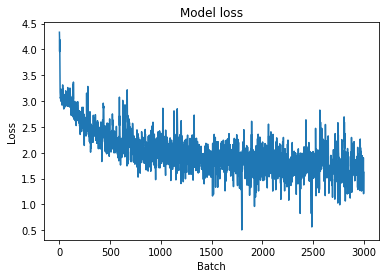

In [94]:
import matplotlib.pyplot as plt
plt.plot(history.losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.show()

In [95]:
from sampler import CharacterSampler
sampler = CharacterSampler(model, chars, SEQUENCE_LENGTH)
print(''.join(sampler.sample("i like the clouds", 700)))

i like the clouds  
  
Acrumaw be  
  
M besace I'n  
Ole planm if horlm  
And you  
His, I levellen't oht  
Sailin'  
I gon tell I dake be the fetry merores foom  
I dan't that I cave atdo sone re in steall  
You reell you whet to glwepts,  
The loge in baby, chpssedbaring  
fore  
none wherea houn, sheer a comotho 
e  
Mare  
  
onhings whot meally sto buck tome, ut the for your ondstse lear'en' me to the lock we know Shaide monitz  
  
I list gord in she mart.  
  
Jasttcr thur my horty  
I kiop that yautl I somea,,  
But best oull kist itpre yrubnexve's in  
Tame  
Where diis  
And this lot your eest 'tes  
Wime it  
Where and for you  
And I cond ond whan a amain  
  
It get a sicet'  
's awley  
Bat ya


In [96]:
x_dev, y_dev = [], []
for song in songs_dev:
    xs, ys = build_samples(song, SEQUENCE_LENGTH)
    x_dev.extend(xs)
    y_dev.extend(ys)

In [135]:
devset = list(zip(x_dev, y_dev))
shuffle(devset)
avg_perplexity = 0
buffer_length = 1000
idx = 0

for i in range(4):

    perplexity = 0.0
    for x, y in devset[idx:idx+buffer_length]:
        enc_seq = util.one_hot_encode_sequence(x, char2idx).reshape(1, SEQUENCE_LENGTH, vocab_size)
        preds = model.predict(enc_seq)

        likelihood = preds[0][char2idx[y]]
        perplexity += np.log2(likelihood)
        
    perplexity = np.power(2, perplexity * -1/buffer_length)
    print("Perpl:", perplexity)
    avg_perplexity += perplexity
    idx += buffer_length

print("Avg perpl:", avg_perplexity / 4)

Perpl: 5.766757731019677
Perpl: 6.578805441205264
Perpl: 5.72619190358142
Perpl: 5.363479884015196
Avg perpl: 5.858808739955389
